# Feedforward Network with Credit Card Fraud

Let us look at a BigDL example with Credit Card Fraud.  We will train a simple, feedforward neural network with 

In [2]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *

from pyspark.sql.functions import col


init_engine()

In [3]:
learning_rate = 0.2
training_epochs = 15
batch_size = 1000
display_step = 1

# Network Parameters
n_input = 30
n_classes = 2
n_hidden_1 = 60 # 1st layer number of features
n_hidden_2 = 60 # 2nd layer number of features

LABELS = ["Normal", "Fraud"]

In [4]:
cc_training = spark.read.csv("../data/creditcardfraud/creditcard.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

In [5]:
df = pd.read_csv("../data/creditcardfraud/creditcard.csv")

In [6]:
cc_training.select('Time', 'V1', 'V2', 'Amount', 'Class').describe().show()

+-------+-----------------+--------------------+--------------------+-----------------+-------------------+
|summary|             Time|                  V1|                  V2|           Amount|              Class|
+-------+-----------------+--------------------+--------------------+-----------------+-------------------+
|  count|           284807|              284807|              284807|           284807|             284807|
|   mean|       94813.8596|2.260907382386083...|6.067406817137794...|88.34961925095207|   1.00172748563062|
| stddev|47488.14595456619|  1.9586958038574867|  1.6513085794769937|250.1201092401879|0.04152718963546483|
|    min|                0|    -56.407509631329|   -72.7157275629303|              0.0|                  1|
|    max|           172792|    2.45492999121121|    22.0577289904909|         25691.16|                  2|
+-------+-----------------+--------------------+--------------------+-----------------+-------------------+



In [7]:
cc_training = cc_training.select([col(c).cast("double") for c in cc_training.columns])



In [8]:
cc_training.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

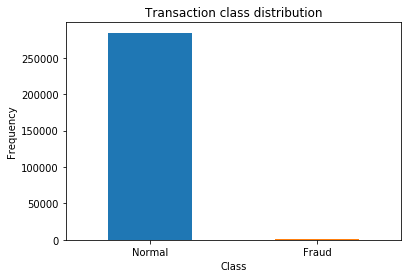

In [9]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes = pd.value_counts(cc_training.select('Class').toPandas()['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [10]:
# get the time to split the data.
splitTime = cc_training.stat.approxQuantile("Time", [0.7], 0.001)[0]

trainingData =cc_training.filter("Time < " + str(splitTime))
validData = cc_training.filter("Time >= " + str(splitTime))

In [11]:
#convert ndarray data into RDD[Sample]

# time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,prediction

def array2rdd(ds):
    #build Sample from ndarrays
    def build_sample(time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,prediction):
        feature = np.array([time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount]).flatten()
        label = np.array(prediction)
        return Sample.from_ndarray(feature, label)
    rdd = ds.map(lambda (time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,prediction): build_sample(time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,prediction))
    return rdd

cc_rdd_train = array2rdd(trainingData.rdd.map(list))
cc_rdd_train.cache()
cc_rdd_train.count()



cc_rdd_test = array2rdd(validData.rdd.map(list))
cc_rdd_test.cache()
cc_rdd_test.count()


85655

In [12]:
# Create model

def multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    #model.add(Reshape([28*28]))
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # Hidden layer with ReLu activation
    model.add(Linear(n_hidden_1, n_hidden_2).set_name('mlp_fc2'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_2, n_classes).set_name('mlp_fc3'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


In [13]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=cc_rdd_train,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=cc_rdd_test,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='multilayer_perceptron-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'multilayer_perceptron-20171110-212612')


In [14]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 210 ms, sys: 60 ms, total: 270 ms
Wall time: 3min 12s


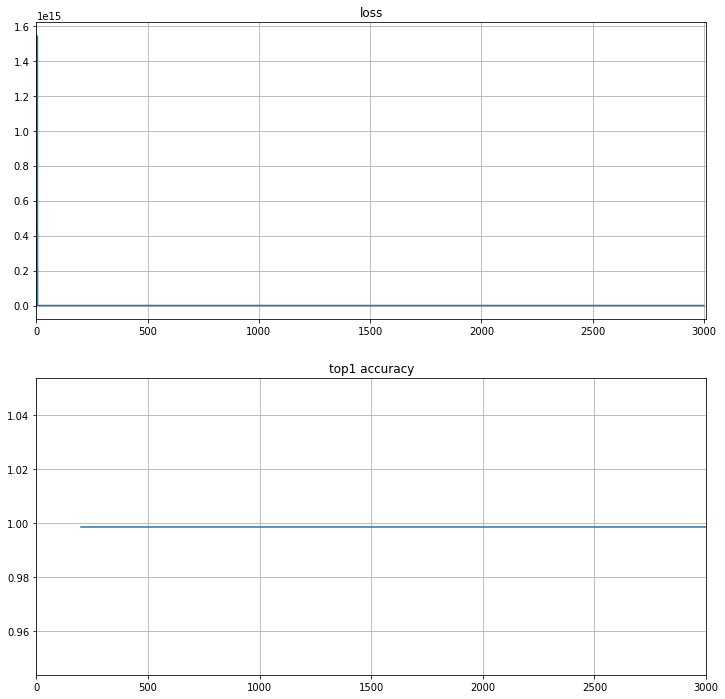

In [15]:

loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0])
plt.title("top1 accuracy")
plt.grid(True)

In [16]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');

NameError: name 'y_true' is not defined

In [ ]:
predictions = trained_model.predict(cc_rdd_test).collect()

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l.to_ndarray()[0] - 1

y_pred = np.array([ map_predict_label(s) for s in predictions])

y_true = np.array([map_groundtruth_label(s.label) for s in cc_rdd_test.collect()])